# Example for training to produce Oxford spikes

## The problem:
From a Poisson spike input, train a multilayer SNN to produce spike raster that resembles Oxford house.
The input and output both consists of 200 neurons each and the spkes span approximately 1900ms.
The input and output spike pair are taken from [SuperSpike repository](https://github.com/fzenke/pub2018superspike).

__Input Spike Raster:__
![](Images/input.png)

__Desired Spike Raster:__
![](Images/output.png)

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

## Load required modules

* SLAYER modules are available as `snn`.{`layer`, `params`, `loss`, `predict`, `io`}
* SLAYER-Loihi module implements `spikeLayer` (defines custom Loihi neuron behaviour) and `quantizeWeights` (defines weight quantization scheme)
* Optimizer implements custom NADAM optimizer


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import slayerSNN as snn
from slayerSNN import loihi as spikeLayer
from slayerSNN import quantize as quantizeParams
from slayerSNN import learningStats as learningStats
from slayerSNN import optimizer as optimizer
# from slayerLoihi import spikeLayer
# from quantizeParams import quantizeWeights
# from learningStats import learningStats
# import optimizer

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN. This file describes the Loihi neuron parameters as well. The contents of `oxford.yaml` looks like this:
```python
simulation:
    Ts: 1
    tSample: 1900
neuron:
    type:     LOIHI
    vThMant:  80 # 5
    vDecay:   128
    iDecay:   1024
    refDelay: 1
    wgtExp:   0
    tauRho:   1
    scaleRho: 1
layer:
    - {dim: 200}
    - {dim: 256}
    - {dim: 200}
training:
    error:
        type: SpikeTime #ProbSpikes #NumSpikes #SpikeTime
```

In [3]:
netParams = snn.params('oxford.yaml')

Ts   = netParams['simulation']['Ts']
Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
Nin  = int(netParams['layer'][0]['dim'])
Nhid = int(netParams['layer'][1]['dim'])
Nout = int(netParams['layer'][2]['dim'])

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules. The difference from SLAYER is to use `spikeLayer` module from slayerLoihi instead of `snn.layer`. `snn.layer` uses PSP approximation of Loihi neuron whereas `spikeLayer` in slayerLoihi is accurate.

In [4]:
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.fc1   = slayer.dense(Nin, Nhid)
        self.fc2   = slayer.dense(Nhid, Nout)
        
    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.fc1(spikeInput))
        spike = self.slayer.delayShift(spike, 1)
        # A minimum axonal delay of 1 tick is required in Loihi hardare
        spike = self.slayer.spikeLoihi(self.fc2(spike))
        spike = self.slayer.delayShift(spike, 1)
        return spike

## Define Loihi parameters generator function
The Loihi neuron parameters are defined in `oxford.yaml` descriptor. This function will be used to save the weights so that they can be used to map the network in Loihi hardware.

In [5]:
def genLoihiParams(net):
    fc1Weights = quantizeWeights.apply(net.fc1.weight, 2).flatten().cpu().data.numpy()
    fc2Weights = quantizeWeights.apply(net.fc2.weight, 2).flatten().cpu().data.numpy()

    np.save('Trained/OxfordFc1.npy', fc1Weights)
    np.save('Trained/OxfordFc2.npy', fc2Weights)

    plt.figure(11)
    plt.hist(fc1Weights, 256)
    plt.title('fc1 weights')

    plt.figure(12)
    plt.hist(fc2Weights, 256)
    plt.title('fc2 weights')

## Initialize the network

In [6]:
# define the cuda device to run the code on
device = torch.device('cuda')

# create a network instance
net = Network(netParams).to(device)

# create snn loss instance
error = snn.loss(netParams, spikeLayer).to(device)

# define optimizer module
# optimizer = torch.optim.SGD(snn.parameters(), lr = 0.001)
# optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)
optimizer = optimizer.Nadam(net.parameters(), lr = 0.01, amsgrad = True)

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


## Read input and desired spikes from file
* `snn.io.read1Dspikes` reads from binary spike file with no spatial layout into spike event.
* `snn.io.event.toSpikeTensor` loads spike event into passed tensor at defined sampling time.

The spike tensor is reshaped into proper tensor dimension to be processed by SLAYER PyTorch.
* The tensor follows NCHWT layout. It is recommended to put the neurons in channed dimension if they do not have spatial orientation.

In [7]:
# Read input spikes and load it to torch tensor
inTD  = snn.io.read1Dspikes('Spikes/input.bs1')
input = inTD.toSpikeTensor(torch.zeros((1, 1, Nin, Ns)), samplingTime=Ts).reshape((1, Nin, 1, 1, Ns)).to(device)

# Read desired spikes and load it to torch tensor
desTD   = snn.io.read1Dspikes('Spikes/output.bs1')
desired = desTD.toSpikeTensor(torch.zeros((1, 1, Nout, Ns)), samplingTime=Ts).reshape((1, Nout, 1, 1, Ns)).to(device)

## Visualize the spike data

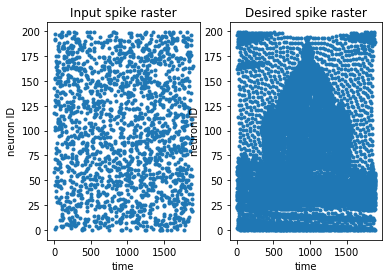

In [8]:
# showTD animation does not work in jupyter session
# snn.io.showTD(snn.io.spikeArrayToEvent(  input.reshape((1, Nin , -1)).cpu().data.numpy()))
# snn.io.showTD(snn.io.spikeArrayToEvent(desired.reshape((1, Nout, -1)).cpu().data.numpy()))
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(inTD.t, inTD.x, '.')
plt.title('Input spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')

plt.subplot(1, 2, 2)
plt.plot(desTD.t, desTD.x, '.')
plt.title('Desired spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.show()


# Run the network
* Run the network for 10000 epochs
* `bestNetwork` is stored for inferencing later

In [9]:
stats = learningStats()

for epoch in range(10000):
    output = net.forward(input)

    loss = error.spikeTime(output, desired)
    
    stats.training.numSamples = 1
    stats.training.lossSum = loss.cpu().data.item()

    if epoch%500 == 0: stats.print(epoch)
        
    stats.training.update()
    
    if stats.training.bestLoss is True: 
        torch.save(net.state_dict(), 'Trained/oxfordNet.pt')
    
    if loss < 1e-5: break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch :          0
loss = 1.2793e+10  

Epoch :        500
loss = 2.0454e+09   (min = 2.0401e+09  )

Epoch :       1000
loss = 1.6531e+09   (min = 1.6225e+09  )

Epoch :       1500
loss = 1.4333e+09   (min = 1.4218e+09  )

Epoch :       2000
loss = 1.3559e+09   (min = 1.2894e+09  )

Epoch :       2500
loss = 1.2245e+09   (min = 1.2109e+09  )

Epoch :       3000
loss = 1.1726e+09   (min = 1.1476e+09  )

Epoch :       3500
loss = 1.1242e+09   (min = 1.1086e+09  )

Epoch :       4000
loss = 1.0684e+09   (min = 1.0638e+09  )

Epoch :       4500
loss = 1.0475e+09   (min = 1.0279e+09  )

Epoch :       5000
loss = 1.0066e+09   (min = 9.8423e+08  )

Epoch :       5500
loss = 9.779e+08    (min = 9.4556e+08  )

Epoch :       6000
loss = 9.4266e+08   (min = 9.2107e+08  )

Epoch :       6500
loss = 9.31e+08     (min = 8.859e+08   )

Epoch :       7000
loss = 9.0615e+08   (min = 8.7695e+08  )

Epoch :       7500
loss = 9.122e+08    (min = 8.5892e+08  )

Epoch :       8000
loss = 8.6009e+08   (min 

## Inference using the best network

In [10]:
net.load_state_dict(torch.load('Trained/oxfordNet.pt'))
output = net.forward(input)

## Plot the Results

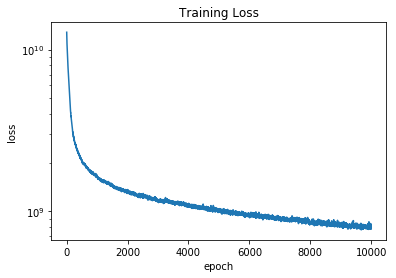

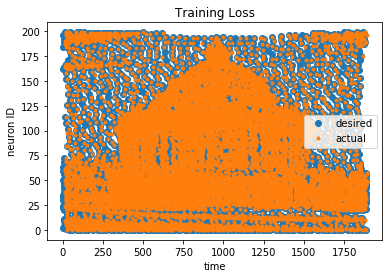

In [11]:
plt.figure(1)
plt.semilogy(stats.training.lossLog)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure(2)
inpAER = np.argwhere(input.reshape((Nin, Ns)).cpu().data.numpy() > 0)
desAER = np.argwhere(desired.reshape((Nout, Ns)).cpu().data.numpy() > 0)
outAER = np.argwhere(output.reshape((Nout, Ns)).cpu().data.numpy() > 0)
plt.plot(desAER[:, 1], desAER[:, 0], 'o', label='desired')
plt.plot(outAER[:, 1], outAER[:, 0], '.', label='actual')
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.legend()

plt.show()

## Generate Loihi parameters
Generate Loihi parameters and spike (input, output and desired) files.

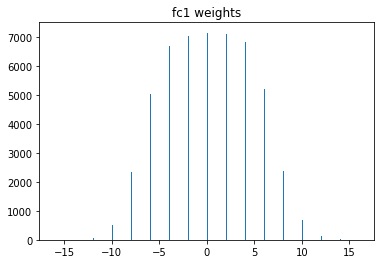

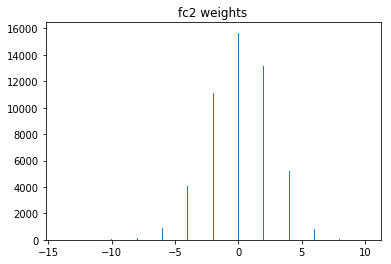

In [12]:
genLoihiParams(net)

np.savetxt('Trained/OxfordInp.txt', inpAER, fmt='%g')
np.savetxt('Trained/OxfordOut.txt', outAER, fmt='%g')
np.savetxt('Trained/OxfordDes.txt', desAER, fmt='%g')

with open('Trained/loss.txt', 'wt') as loss:
    loss.write('#%11s\r\n'%('Train'))
    for i in range(len(stats.training.lossLog)):
        loss.write('%12.6g\r\n'%(stats.training.lossLog[i]))

